# Machine Learning Work Flow, Pipe Line

**주의사항**
* preview)를 보고 할 것.
* 시각화에 날짜 붙이는 것에 너무 집착하지 말자.
    * 판다스를 경유하면 편하다.

# Training Work Flow

**무엇을 무슨 순서로 했는가?**
1. 여기에
2. 채워서
3. 적으면
4. 됩니다.

## 01. Data Loading

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
data_path = 'https://raw.githubusercontent.com/RayleighKim/Example_datasets/master/Bike-Sharing-Dataset/hour.csv'
rides = pd.read_csv(data_path)

## 02. Train/Validation/Test Split
**실습**
1. 데이터를 분리 하시오.
    * 마지막 21일은 test_data로 분리
    * 그 다음 60일(-81 ~ -21)은 val_data로 분리
    * 나머지는 train_data로 분리

**주의사항**
* 이걸 제일 먼저 해야 한다.
* Training phase에서는
    1. 모든 탐색, 전처리규칙제작 등은 training set에서.
    2. validation셋에 대하여 고민해보자.


In [0]:
test_data = rides[-21*24:]
val_data = rides[-81*24:-21*24]
train_data = rides[:-81*24]

## 03. EDA for Feature Engineering

* EDA는 명확한 목적하에, 반드시 workflow에 도움이 되는 결과를 도출해야 함.
* EDA를 검색해봐도 좋음.

In [0]:
train_data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


무엇이 보이는가?


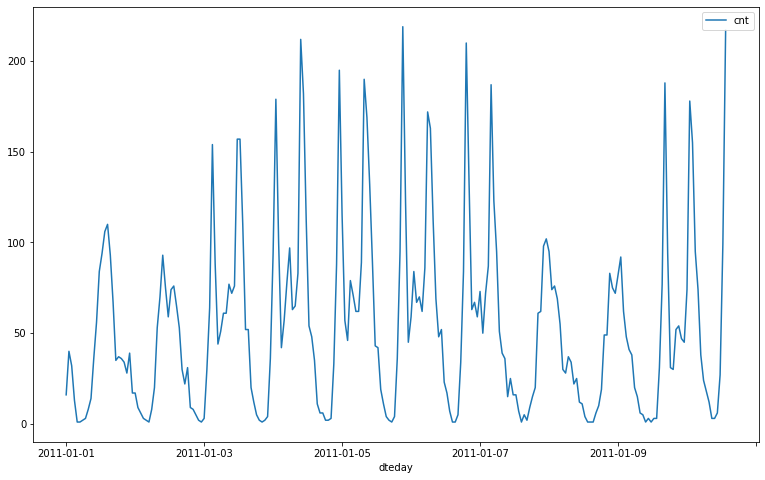

In [0]:
print('무엇이 보이는가?')
train_data[:24*10].plot(x='dteday', y='cnt', figsize=(13,8) )
# train_data[:24*10].plot(x='dteday', y=['registered','cnt'], figsize=(13,8) )

**EDA의 결론을 적으시오**<br>
Hint : Feature Engineering/Extraction 계획을 하시오.<br>
[궁금할지도 모르는 내용](https://datascience.stackexchange.com/questions/29006/feature-selection-vs-feature-extraction-which-to-use-when)


## 04. Feature Engineering.

**주의사항** : 여기에서 제작 한 것을, test셋에서도 사용하게 될 것이다. 마구잡이로 하면 안됨

1. any ideas : ?
1. dummy : ?
2. scaling : ?
3. drop : ?
4. impute : ?


## Dummy & Drop

In [0]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']

train_data = pd.get_dummies(train_data, columns=dummy_fields)
val_data = pd.get_dummies(val_data, columns=dummy_fields)
test_data = pd.get_dummies(test_data, columns=dummy_fields)

fields_to_drop = ['instant', 'dteday']

train_data.drop(fields_to_drop, axis=1, inplace=True)
val_data.drop(fields_to_drop, axis=1, inplace=True)
test_data.drop(fields_to_drop, axis=1, inplace=True)

In [0]:
train_col = set(train_data.columns)
val_col = set(val_data.columns)
test_col = set(test_data.columns)

for feature in (train_col-val_col) :
    val_data[feature] = 0

for feature in (train_col-test_col) :
    test_data[feature] = 0

In [0]:
val_data = val_data[train_data.columns]
test_data = test_data[train_data.columns]

## Scaling

In [0]:
train_data.columns

In [0]:
quant_features = ['temp', 'atemp', 'hum','windspeed']

means = train_data[quant_features].mean()
stds = train_data[quant_features].std()

train_data[quant_features] = (train_data[quant_features]-means)/stds
val_data[quant_features] = (val_data[quant_features]-means)/stds
test_data[quant_features] = (test_data[quant_features]-means)/stds

Feature Engineering 파트에서 사용한 것들을 diagram으로 잘 그려두기.

In [0]:
targets= ['casual', 'registered', 'cnt']

x_train, y_train = train_data.drop(targets, axis=1), train_data['cnt']
x_val, y_val = val_data.drop(targets, axis=1), val_data['cnt']
x_test, y_test = test_data.drop(targets, axis=1), test_data['cnt']


## 05. Modeling & Hyperparameter tuning

* Validation set을 적극 활용해보자.
* 여러 모델 다 사용해봐도 좋음.
* **강사는 하나만**

In [0]:
from sklearn.neural_network import MLPRegressor

In [0]:
ann = MLPRegressor(hidden_layer_sizes=(64,32),early_stopping=True,
                   max_iter=2000, verbose=True)
ann.fit(x_train, y_train)

In [0]:
y_tr_p = ann.predict(x_train)
y_va_p = ann.predict(x_val)
y_te_p = ann.predict(x_test)

In [0]:
from sklearn.metrics import mean_squared_error as mse, r2_score

In [0]:
rmse_ann_tr = mse(y_train, y_tr_p)**(1/2)
rmse_ann_va = mse(y_val, y_va_p)**(1/2)


r2_ann_tr = r2_score(y_train, y_tr_p)
r2_ann_va = r2_score(y_val, y_va_p)


print('training // 뉴럴넷의 RMSE : {:.3f}, R^2: {:.5f}'.format(rmse_ann_tr, r2_ann_tr))
print('validation // 뉴럴넷의 RMSE : {:.3f}, R^2: {:.5f}'.format(rmse_ann_va, r2_ann_va))


training // 뉴럴넷의 RMSE : 33.700, R^2: 0.96456
validation // 뉴럴넷의 RMSE : 65.180, R^2: 0.89992


## 06. Evaluation on Test set & make a pipeline

* Go? or Not to go?
* 모든 규칙을 정리하여 파이프라인을 제작하자.

In [0]:
rmse_ann_te = mse(y_test, y_te_p)**(1/2)
r2_ann_te = r2_score(y_test, y_te_p)
print('test // 뉴럴넷의 RMSE : {:.3f}, R^2: {:.5f}'.format(rmse_ann_te, r2_ann_te))

test // 뉴럴넷의 RMSE : 82.719, R^2: 0.68620


# ML Pipeline for system

Training Work Flow 의 모든 것을 재활용 한다.
* 처음에 pipeline부터 먼저 그린다. 같이 그리자!

**To-Do**
1. Training Phase : **전체 데이터를 이용하여 모델을 만든다.**(train/valid/test안나눈다.)
    * 하지만 이 실습에서는, 주어진 데이터만을 이용해야 하기 때문에 마지막 21일을 new_data로 떼어둔다.
    * 나머지 데이터를 old_data로 떼어둔다.
    * new_data는 마치 진짜로 데이터가 새로 들어올 때 처럼 사용할 것이다.

3. Prediction Phase :
    * new_data를 이용하여 예측값을 만들어본다.
4. Monitoring ?

## 01. Training Phase for model serving

* Training Work Flow의 여러 규칙들을, 전체 데이터(old_data)를 이용하여 다시 제작하면 됨.


In [0]:
data_path = 'https://raw.githubusercontent.com/RayleighKim/Example_datasets/master/Bike-Sharing-Dataset/hour.csv'
rides = pd.read_csv(data_path)

new_data = rides[-21*24:]
old_data = rides[:-21*24]

In [0]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
old_data = pd.get_dummies(old_data, columns=dummy_fields)

fields_to_drop = ['instant', 'dteday']
old_data.drop(fields_to_drop, axis=1, inplace=True)


In [0]:
quant_features = ['temp', 'atemp', 'hum','windspeed']

means = old_data[quant_features].mean()
stds = old_data[quant_features].std()

old_data[quant_features] = (old_data[quant_features]-means)/stds

In [0]:
targets= ['casual', 'registered', 'cnt']

x_old, y_old = old_data.drop(targets, axis=1), old_data['cnt']

In [0]:
from sklearn.neural_network import MLPRegressor
ann = MLPRegressor(hidden_layer_sizes=(64,32),early_stopping=True,
                   max_iter=2000, verbose=True)
ann.fit(x_old, y_old)

Iteration 1, loss = 33280.93899782
Validation score: -0.829917
Iteration 2, loss = 22430.75498535
Validation score: 0.161782
Iteration 3, loss = 11085.26055656
Validation score: 0.421068
Iteration 4, loss = 9142.35065566
Validation score: 0.498434
Iteration 5, loss = 7955.81855804
Validation score: 0.564191
Iteration 6, loss = 6937.11947432
Validation score: 0.620816
Iteration 7, loss = 6063.86073324
Validation score: 0.669641
Iteration 8, loss = 5345.39477350
Validation score: 0.707256
Iteration 9, loss = 4831.37772661
Validation score: 0.733329
Iteration 10, loss = 4474.76110047
Validation score: 0.751754
Iteration 11, loss = 4234.35261854
Validation score: 0.764707
Iteration 12, loss = 4033.56381191
Validation score: 0.775737
Iteration 13, loss = 3862.31480957
Validation score: 0.786365
Iteration 14, loss = 3694.18508122
Validation score: 0.796179
Iteration 15, loss = 3520.61963238
Validation score: 0.806846
Iteration 16, loss = 3341.63586077
Validation score: 0.817908
Iteration 17,

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=True, epsilon=1e-08,
             hidden_layer_sizes=(64, 32), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=2000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=True,
             warm_start=False)

## 02. Prediction Phase

**아래 내용들을 이용하여 진행한다.**
* 위 Training Phase에서 제작한 규칙
* 위 Training Phase에서 제작한 모델

In [0]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
new_data = pd.get_dummies(new_data, columns=dummy_fields)

fields_to_drop = ['instant', 'dteday']
new_data.drop(fields_to_drop, axis=1, inplace=True)

In [0]:
old_col = set(old_data.columns)
new_col = set(new_data.columns)

for feature in (old_col-new_col) :
    new_data[feature] = 0

old_data = old_data[old_data.columns]    

In [0]:
new_data[quant_features] = (new_data[quant_features]-means)/stds

In [0]:
targets= ['casual', 'registered', 'cnt']

x_new, y_new = new_data.drop(targets, axis=1), new_data['cnt']

In [0]:
y_new_p = ann.predict(x_new)

## 03. Monitoring을 한다면?
** Discussion **

In [0]:
new_df = rides[-21*24:]
new_df['cnt_pred'] = y_new_p

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


rmse : 195.18098487591143


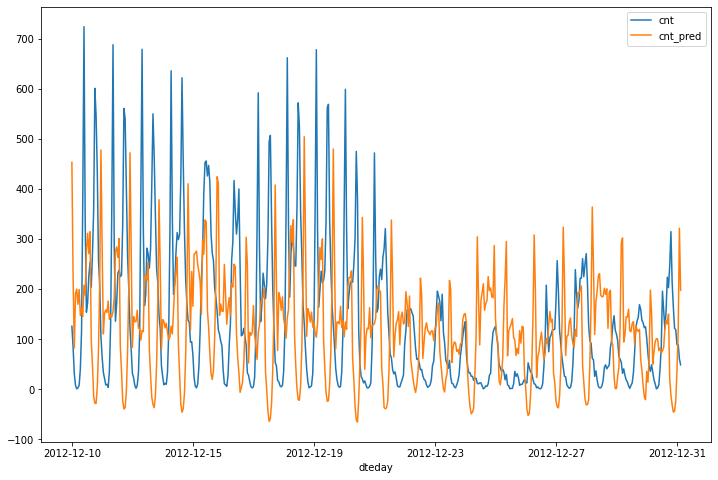

In [0]:
print('rmse :',mse(y_new, y_new_p)**(1/2))
new_df.plot(x='dteday', y=['cnt', 'cnt_pred'], figsize=(12,8))
